c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


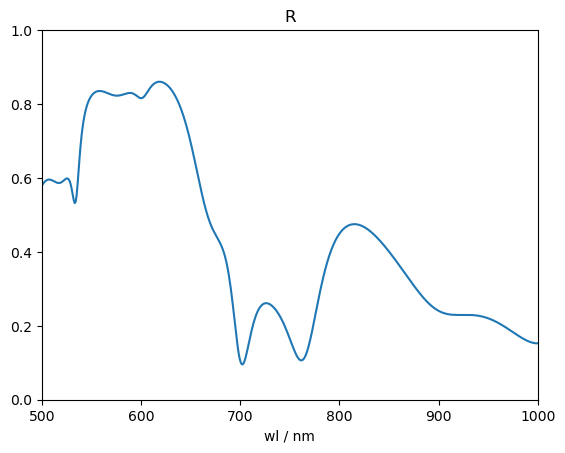

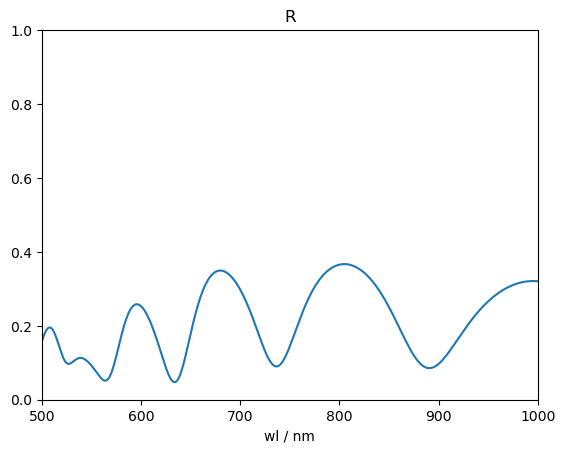

In [1]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target_30layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film
plot_film(f_target_30layers)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film
plot_film(f_target_4layers)

Should be 1 dim array! (run 0)
Should be 1 dim array! (run 0)
Should be 1 dim array! (run 0)


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:2865: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


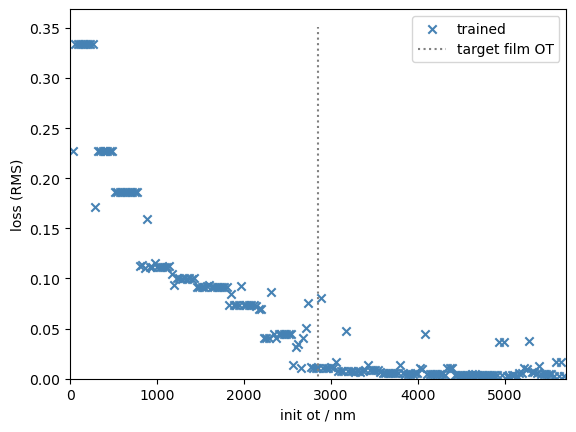

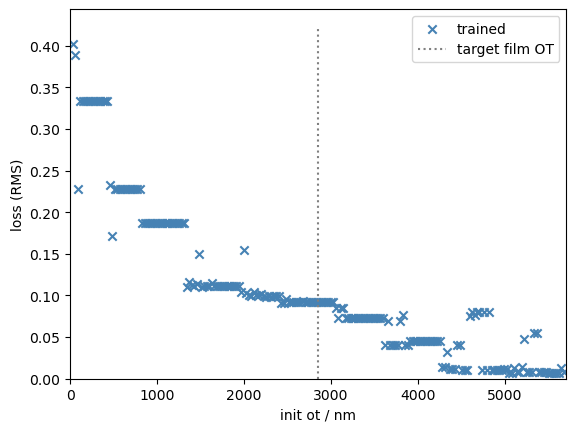

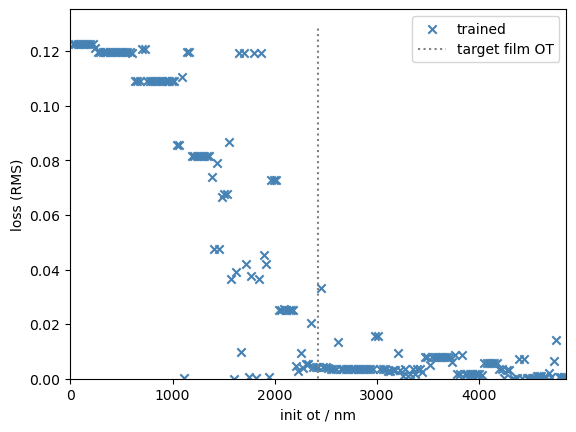

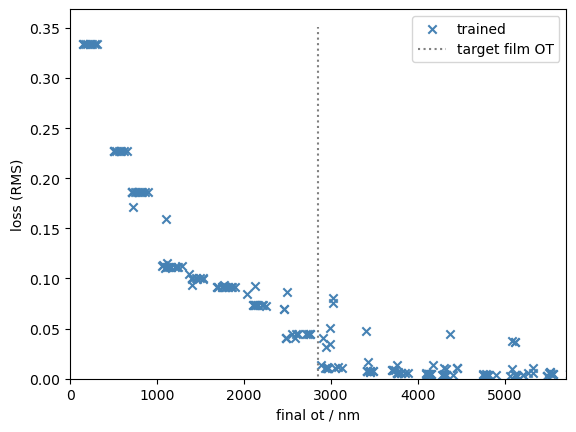

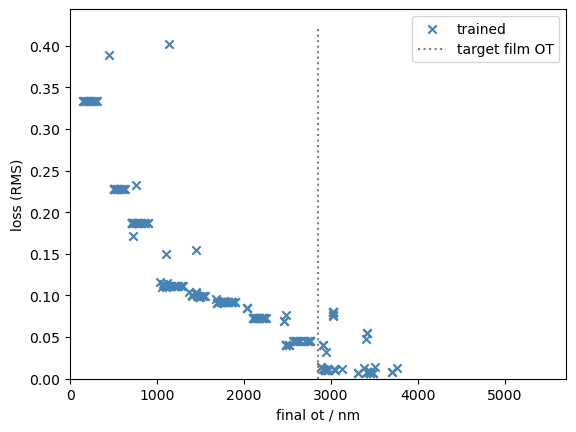

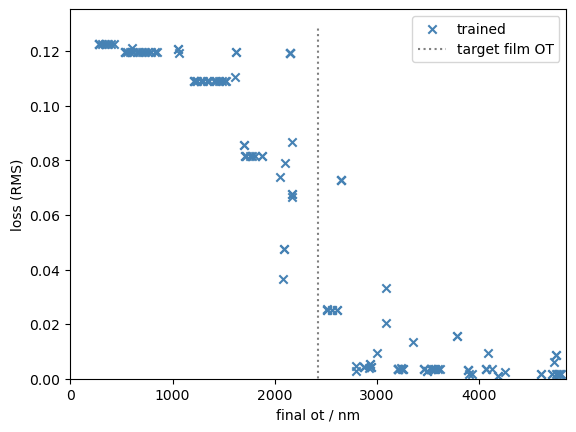

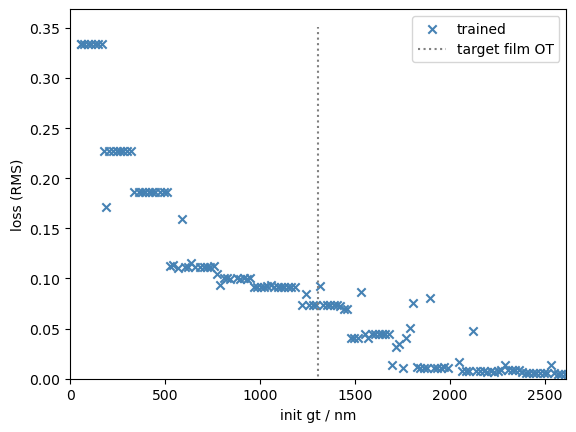

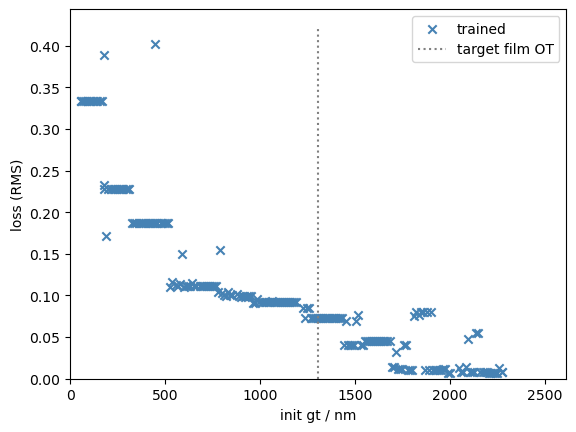

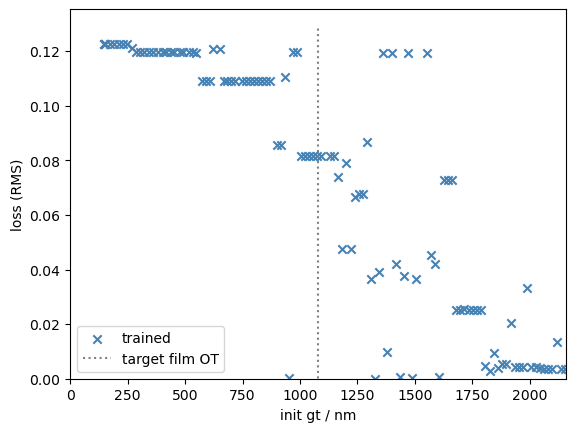

In [18]:
# Load trained films data and construct Design objects


def load_designs(file_dir, f_target):
    designs = []
    for run_idx in range(200):
        try:
            design = DesignSimple(f_target,
                                FilmSimple('SiO2', 
                                            'TiO2',
                                            'SiO2',
                                            np.loadtxt(file_dir + f'run_{run_idx}/final')*1000.
                                            ),
                                init_ot=run_idx / 200 * 2 * f_target.get_optical_thickness(wl), # init ot is ratio * target ot, run 199 is 2 target ot
                                init_gt=(np.loadtxt(file_dir + f'run_{run_idx}/iter_0')*1000.).sum()
                                )
            design.film.add_spec_param(inc_ang=INC_ANG, wls=WLS)
            design.film.calculate_spectrum()
            design.calculate_loss()

            designs.append(design)
        except Exception as e:
            print(e, f"(run {run_idx})")
            continue # skip invalid d
    return designs


def plot(design_list, x='wrt init ot'):
    target_ot = design_list[0].target_film.get_optical_thickness(wl)
    target_thickness = design_list[0].target_film.get_d().sum()
             
    fig, ax = plt.subplots(1, 1)

    if x == 'wrt init ot':
        for design in design_list:
            ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.init_ot, design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')

        ax.set_xlabel('init ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'wrt final ot':
        for design in design_list:
            ax.scatter(design.film.get_optical_thickness(wl), design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.film.get_optical_thickness(wl), design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
        
        ax.set_xlabel('final ot / nm')
        ax.set_xlim(0, target_ot * 2)

    elif x == 'wrt init gt': # geometrical thickness
        for design in design_list:
            ax.scatter(design.init_gt, design.loss, c='steelblue', marker='x')
        # scatter the first dot for the legend
        ax.scatter(design.init_gt, design.loss, c='steelblue', marker='x', label='trained')
        ax.plot([target_thickness, target_thickness], ax.get_ylim(), label='target film OT', c='gray', ls=':')
        
        ax.set_xlabel('init gt / nm')
        ax.set_xlim(0, target_thickness * 2)

    ax.legend()
    ax.set_ylabel('loss (RMS)')
    ax.set_ylim(0, None) # set lower bound of y to zero



    return fig

load_file_dir_SiO2 = './../raw_design_result/50iters_0to2OT_200run_SiO2/'
load_file_dir_TiO2 = './../raw_design_result/50iters_0to2OT_200run_TiO2/'
load_file_dir_SiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'

save_fig_dir_SiO2 = './figs/50iters_0to2OT_200run_SiO2/'
save_fig_dir_TiO2 = './figs/50iters_0to2OT_200run_TiO2/'
save_fig_dir_SiO2_target_4layers = './figs/50iters_0to2OT_200run_SiO2_target4layers/'


designs_SiO2 = load_designs(load_file_dir_SiO2, f_target_30layers)        
designs_TiO2 = load_designs(load_file_dir_TiO2, f_target_30layers)
designs_SiO2_target4 = load_designs(load_file_dir_SiO2_target_4layers, f_target_4layers)

plot(designs_SiO2, 'wrt init ot').savefig(save_fig_dir_SiO2, dpi=300)
plot(designs_TiO2, 'wrt init ot').savefig(save_fig_dir_TiO2, dpi=300)
plot(designs_SiO2_target4, 'wrt init ot').savefig(save_fig_dir_SiO2_target_4layers, dpi=300)

plot(designs_SiO2, 'wrt final ot').savefig(save_fig_dir_SiO2, dpi=300)
plot(designs_TiO2, 'wrt final ot').savefig(save_fig_dir_TiO2, dpi=300)
plot(designs_SiO2_target4, 'wrt final ot').savefig(save_fig_dir_SiO2_target_4layers, dpi=300)

plot(designs_SiO2, 'wrt init gt').savefig(save_fig_dir_SiO2, dpi=300)
plot(designs_TiO2, 'wrt init gt').savefig(save_fig_dir_TiO2, dpi=300)
plot(designs_SiO2_target4, 'wrt init gt').savefig(save_fig_dir_SiO2_target_4layers, dpi=300)

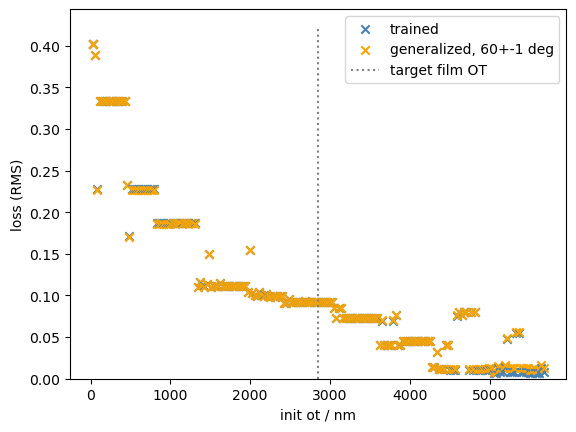

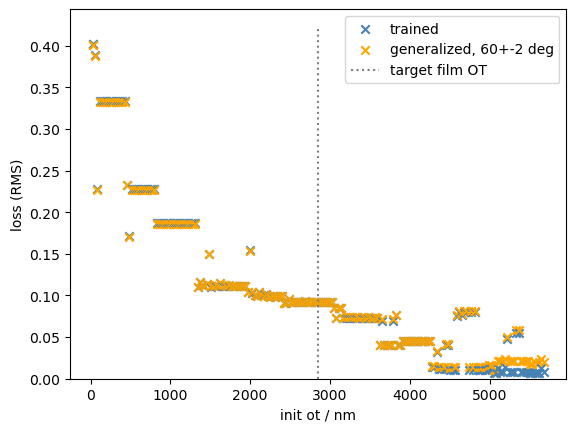

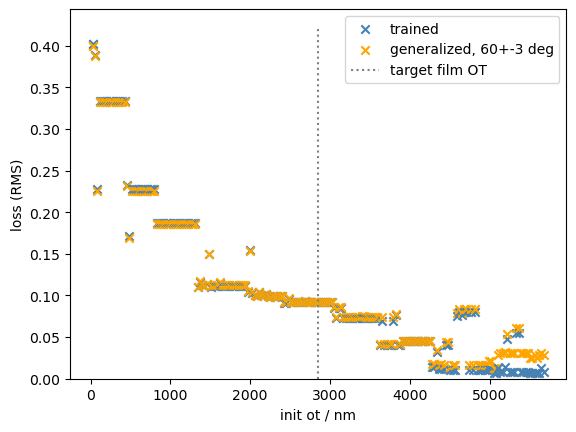

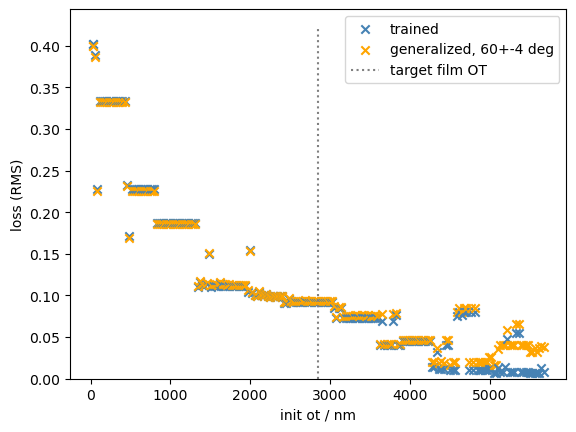

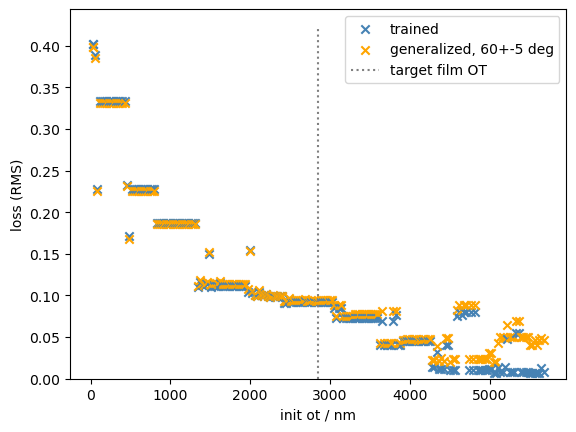

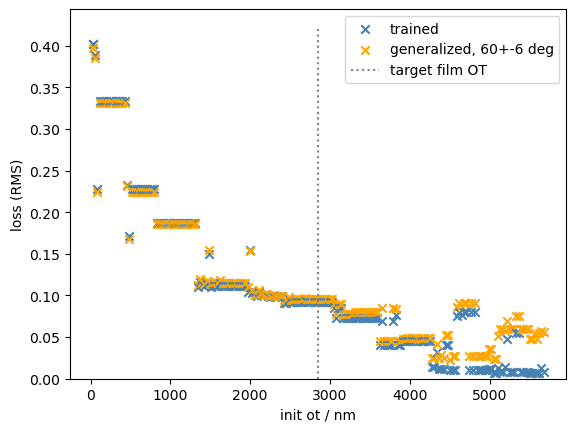

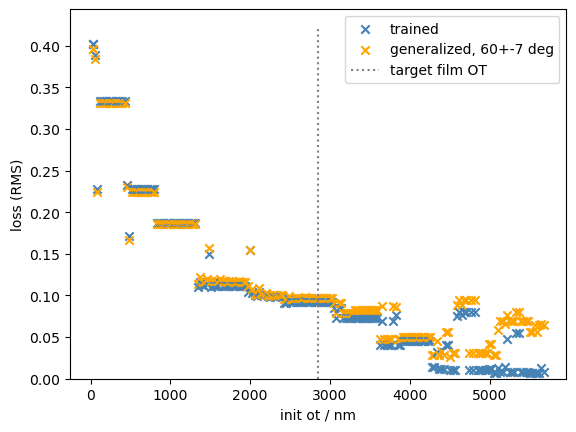

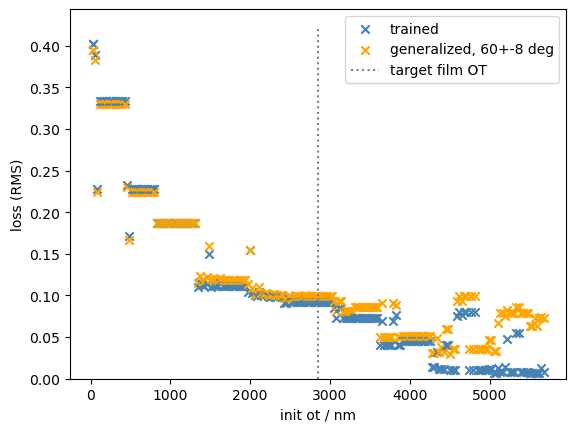

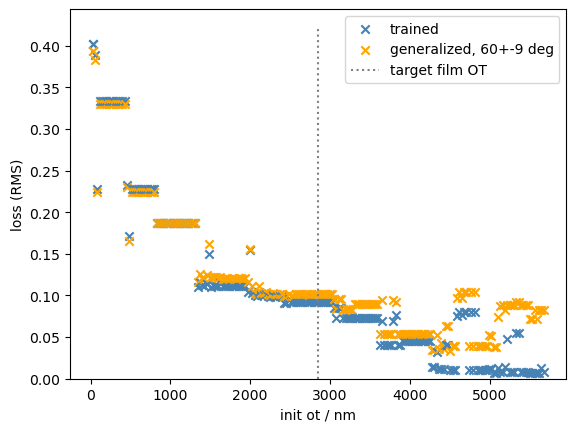

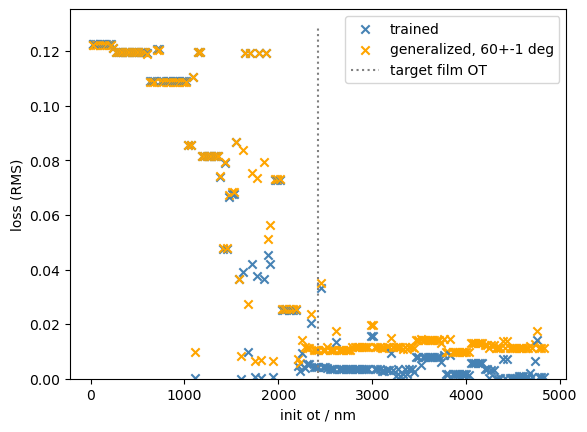

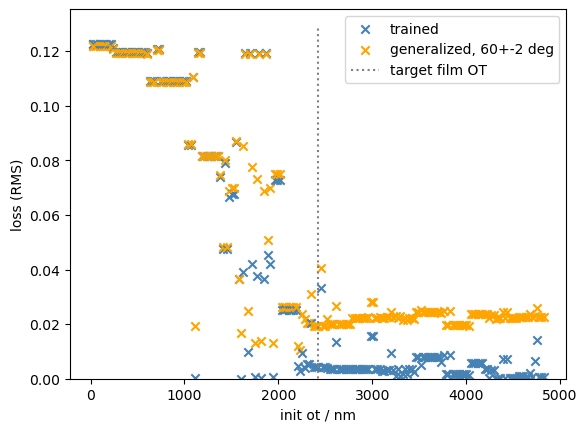

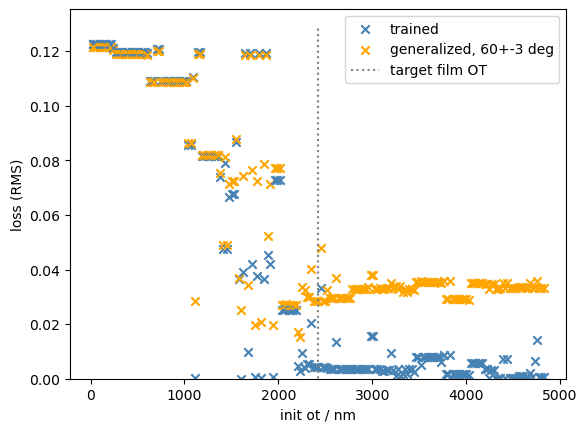

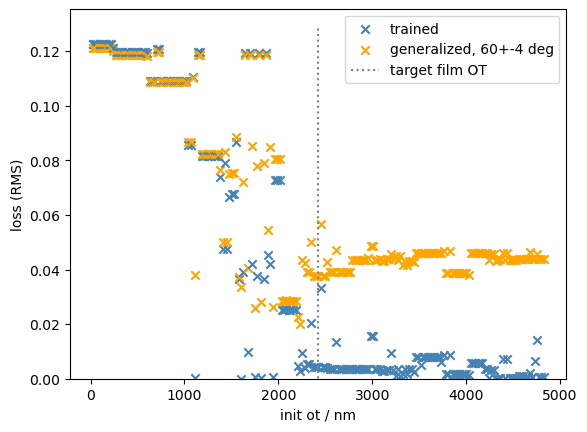

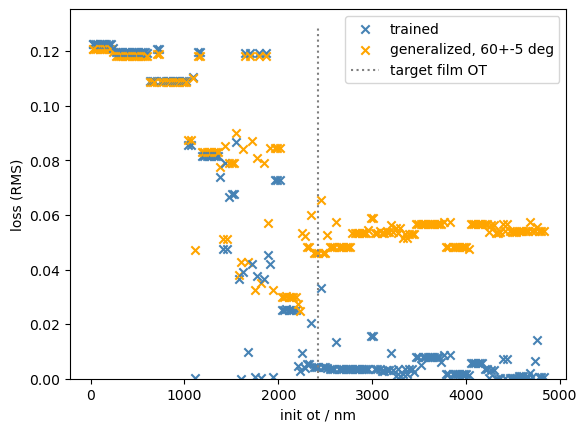

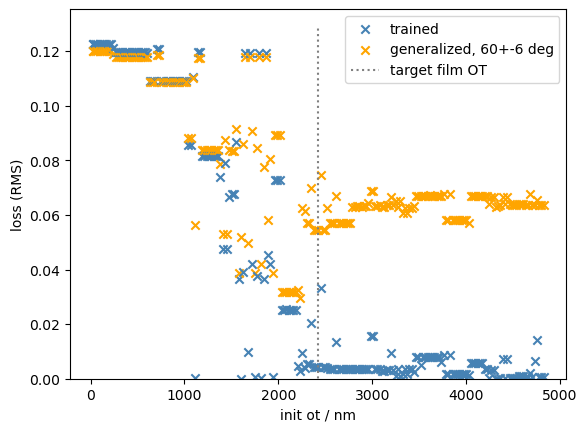

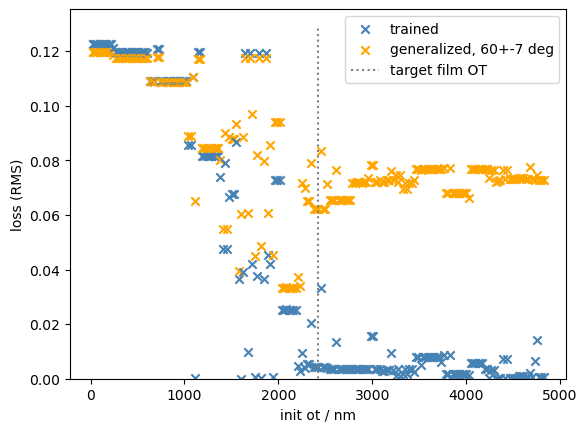

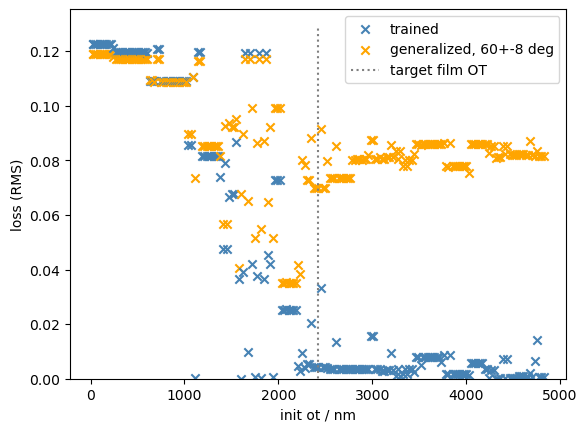

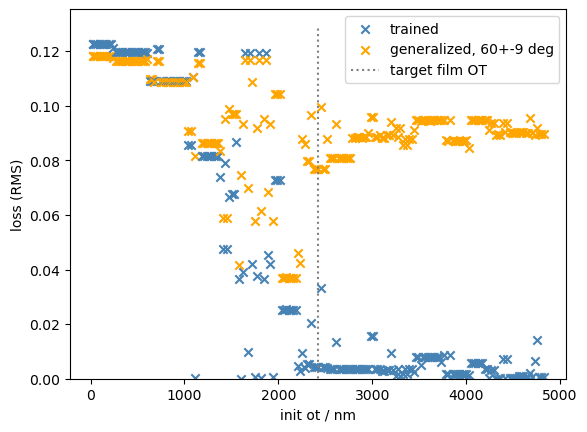

In [26]:

def plot_generalization(designs, file_dir):
    gen_angs_biases = list(range(1, 10)) + list(range(10, 35, 5))

    gen_number = len(gen_angs_biases)

    for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
        gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

        def generalize(designs):
            gen_designs = []
            for design in designs:
                gen_design = copy.deepcopy(design)
                for inc_ang in gen_angs:
                    gen_design.target_film.add_spec_param(inc_ang, WLS)
                    gen_design.film.add_spec_param(inc_ang, WLS)
                gen_design.calculate_loss()
                gen_designs.append(gen_design)
            return gen_designs

        gen_designs = generalize(designs)

        def plot(design_list, gen_designs_list):
            fig, ax = plt.subplots(1, 1)
            for design, gen_design in zip(design_list, gen_designs_list):
                ax.scatter(design.final_ot, design.loss, c='steelblue', marker='x')
                ax.scatter(gen_design.final_ot, gen_design.loss, c='orange', marker='x')

            # scatter the first dot for the legend
            design, gen_design = designs[0], gen_designs[0]
            ax.scatter(design.final_ot, design.loss, c='steelblue', marker='x', label='trained')
            ax.scatter(gen_design.final_ot, gen_design.loss, c='orange', marker='x', label=f'generalized, 60+-{gen_angs_bias} deg')

            target_ot = design.target_film.get_optical_thickness(wl)
            ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
            
            
            ax.legend()
            ax.set_xlabel('init ot / nm')
            ax.set_ylabel('loss (RMS)')
            ax.set_ylim(0, None) # set lower bound of y to zero
            return fig
        
        # plot one loss-init ot figure each iter

        plot(designs, gen_designs).savefig(file_dir+f"gen_60+-{gen_angs_bias}-wrt_final_ot.png", dpi=300)


# plot_generalization(designs_SiO2, save_fig_dir_SiO2)
plot_generalization(designs_TiO2, save_fig_dir_TiO2)
plot_generalization(designs_SiO2_target4, save_fig_dir_SiO2_target_4layers)




c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


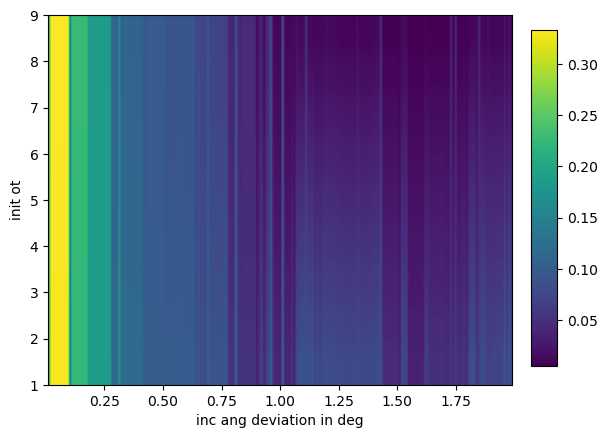

In [20]:
def plot_generalization_2d_imag(designs):
    gen_angs_biases = list(range(1, 10))
    gen_number = len(gen_angs_biases)
    gen_loss_arr = np.empty((gen_number, len(designs)))

    for i, gen_angs_bias in zip(range(gen_number), gen_angs_biases):
        gen_angs = [60. - gen_angs_bias, 60. + gen_angs_bias]

        def generalize(designs):
            gen_designs = []
            for design in designs:
                gen_design = copy.deepcopy(design)
                for inc_ang in gen_angs:
                    gen_design.target_film.add_spec_param(inc_ang, WLS)
                    gen_design.film.add_spec_param(inc_ang, WLS)
                gen_design.calculate_loss()
                gen_designs.append(gen_design)
            return gen_designs

        gen_designs = generalize(designs)

        for j in range(len(gen_designs)):
            gen_loss_arr[i, j] = gen_designs[j].loss

    fig, ax = plt.subplots(1, 1)
    target_ot = design.target_film.get_optical_thickness(wl)
    im = ax.imshow(gen_loss_arr,
            aspect='auto',
            extent=(
                designs[0].init_ot / target_ot,
                designs[-1].init_ot / target_ot,
                gen_angs_biases[0],
                gen_angs_biases[-1]
            )
        )
    ax.set_xlabel('inc ang deviation in deg')
    ax.set_ylabel('init ot')

    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
    fig.colorbar(im, cax=cbar_ax)